**Implementação de modelo utilizando algoritmo de Regressão Logística**
<br>
<br>
**Autor**: Caio Augusto de Souza Mota (*caiomota802@gmail.com*)

Data: 09/06/2021

**Revisor**: Carlos Eduardo Beluzo (*cbeluzo@gmail.com*)
<br>
<br>
*Codigo adaptado de Baligh Mnassri disponivel em: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python/notebook*

---
Este código é parte do Trabalho de Conclusão de Curso apresentado como exigência parcial para obtenção do diploma do Curso de Tecnologia em Análise e Desenvolvimento de Sistemas do Instituto Federal de Educação, Ciência e Tecnologia de São Paulo Câmpus Campinas.



# 1. Importação de Bibliotecas, carga de dados e funções

In [ ]:
# instalando o Synapse Client
! pip install synapseclient

     |████████████████████████████████| 215kB 7.6MB/s 
     |████████████████████████████████| 3.2MB 12.8MB/s 
  Created wheel for secretstorage: filename=SecretStorage-2.3.1-cp37-none-any.whl size=13970 sha256=42dc779eeff71c2f6d5051d74045eb6619f760c8a201b55cfde5d90807ddedcb
  Stored in directory: /root/.cache/pip/wheels/4e/5b/1b/be8c8a830a0243af85b2946a0aece2c6743d7f7f946977ed67
Successfully built secretstorage


In [ ]:
import os
import synapseclient as syna
from getpass import getpass

import numpy as np
from math import sqrt
import pandas as pd 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import roc_curve, plot_roc_curve, accuracy_score, auc, log_loss, confusion_matrix, classification_report

import matplotlib.pyplot as plt 
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

#### Funções auxiliares

In [ ]:
# Matrix de Confusão
def my_cm(p_cm, p_acc):
  plt.figure(figsize=(3,3))
  sns.heatmap(p_cm, annot=True, fmt=".0f", linewidths=.9, square=True, cmap='Blues_r')
  plt.ylabel('Valores reais')
  plt.xlabel('Valores preditos')
  plt.title('Acurácia: %2.3f' % p_acc, size=12)

## 1.1 Carregando base de dados disponível no Synapse

In [ ]:
# BRNeodeath
# Recuperando a base de dados do repositório de dados Synapse
syn = syna.Synapse() 
syn.login(input('Sybapse User: '), getpass('Passwd:')) 
 
# Obtendo um ponteiro e baixando os dados
dataset = syn.get(entity='syn25575811') # ID do dataset BRNeodeath

df_ori = pd.read_csv(dataset.path)

Sybapse User: caiomota802@gmail.com
Passwd:··········
Welcome, Caio Mota!



## 1.2 Divisão da base em conjunto para treino e teste do modelo de ML

In [ ]:
df = df_ori.sample(frac=1)
print("Shape:", df.shape, "\n")
df.head()

Shape: (6760222, 29) 



,Unnamed: 0,maternal_age,tp_maternal_schooling,tp_marital_status,tp_maternal_race,num_live_births,num_fetal_losses,num_previous_gestations,num_normal_labors,num_cesarean_labor,tp_pregnancy,newborn_weight,gestaional_week,cd_apgar1,cd_apgar5,has_congenital_malformation,tp_newborn_presentation,num_prenatal_appointments,tp_labor,was_cesarean_before_labor,was_labor_induced,tp_childbirth_care,tp_robson_group,is_neonatal_death,birth_date,death_date,birth_year,uf,id
6320935,6320935,27,5,1,1,0,0,0,0,0,1,3240,39,9,10,2,9,7,2,9,2,5,11,0,2016-10-18,NaN,2016,MG,13645713
4326756,4326756,35,1,1,5,2,0,2,2,0,1,3145,38,8,9,2,1,5,1,9,2,5,3,0,2015-11-29,NaN,2015,RS,25300049
1850457,1850457,24,4,5,4,2,0,2,1,1,1,817,32,5,8,2,1,5,1,9,2,2,10,0,2014-10-27,NaN,2014,MA,10749788
6519241,6519241,27,4,1,4,4,0,4,4,0,1,2950,37,9,10,2,1,1,1,3,2,1,3,0,2016-11-24,NaN,2016,RS,25516757
1232531,1232531,35,5,2,4,0,0,0,0,0,1,3255,37,9,10,2,1,15,2,2,2,5,1,0,2014-07-16,NaN,2014,SP,650249


In [ ]:
# Todas as "Features" da base de dados
features = ['maternal_age', 'tp_maternal_schooling', 'tp_marital_status',
               'tp_maternal_race', 'num_live_births','num_fetal_losses',
               'num_previous_gestations', 'num_normal_labors', 'num_cesarean_labor',
               'tp_pregnancy', 'newborn_weight', 'gestaional_week',
               'cd_apgar1', 'cd_apgar5', 'has_congenital_malformation',
               'tp_newborn_presentation', 'num_prenatal_appointments', 'tp_labor',
               'was_cesarean_before_labor', 'was_labor_induced', 'tp_childbirth_care',
               'tp_robson_group']

target = ['is_neonatal_death']

# Separação das features e do "target" para serem usados no modelo posteriormente
xArray =  df[features]
yArray =  df[target]

# "Split" do dataset para Treino e Teste do modelo usando 90% para o treino e 10% para teste
xTreino, xTeste, yTreino, yTeste = train_test_split(xArray, yArray, test_size=0.1 ,random_state=42)

In [ ]:
print(xTreino.shape)
print(xTeste.shape)
print(yTreino.shape)
print(yTeste.shape)

(6084199, 22)
(676023, 22)
(6084199, 1)
(676023, 1)


# 2. Aplicação de modelos de Machine Learning: Logistic Regression

---



## Usando particionamento 90/10

In [ ]:
logreg = LogisticRegression()

logreg.fit(xTreino, yTreino)
y_pred = logreg.predict(xTeste)
y_pred_proba = logreg.predict_proba(xTeste)[:, 1]

[fpr, tpr, thr] = roc_curve(yTeste, y_pred_proba)

print('Treino/Teste resultados divididos %s:' % logreg.__class__.__name__)
print("Accuracy is %2.3f" % accuracy_score(yTeste, y_pred))
print("Log_loss is %2.3f" % log_loss(yTeste, y_pred_proba))
print("AUC is %2.3f" % auc(fpr, tpr))

Treino/Teste resultados divididos LogisticRegression:
Accuracy is 0.995
Log_loss is 0.021
AUC is 0.935


#### Curva ROC

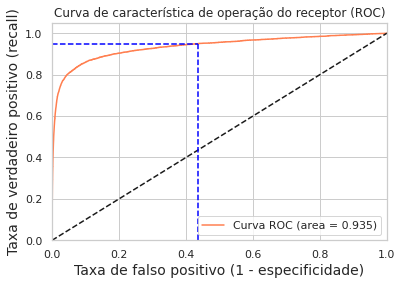

Usando um limite de 0.001 garante uma sensibilidade de 0.950 e uma especificidade de 0.563, ou seja, uma taxa de falsos positivos de 43.66%.


<Figure size 432x288 with 0 Axes>

In [ ]:
idx = np.min(np.where(tpr > 0.95)) 

plt.figure()
plt.plot(fpr, tpr, color='coral', label='Curva ROC (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo (1 - especificidade)', fontsize=14)
plt.ylabel('Taxa de verdadeiro positivo (recall)', fontsize=14)
plt.title('Curva de característica de operação do receptor (ROC)')
plt.legend(loc="lower right")
plt.show()

plt.savefig('ROC_90_10.png', dpi=300)

print("Usando um limite de %.3f " % thr[idx] + "garante uma sensibilidade de %.3f " % tpr[idx] +  
      "e uma especificidade de %.3f" % (1-fpr[idx]) + 
      ", ou seja, uma taxa de falsos positivos de %.2f%%." % (np.array(fpr[idx])*100))

#### Matrix de Confusão

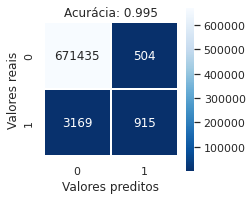

In [ ]:
acc = accuracy_score(yTeste, y_pred)
my_cm(confusion_matrix(yTeste, y_pred), acc)
plt.savefig('CM_90_10.png', dpi=300)

#### Relatório de Classificação

In [ ]:
print(classification_report(yTeste, y_pred))
report = classification_report(yTeste, y_pred, output_dict=True)
round(pd.DataFrame(report).transpose(),2).to_csv('ClassRep_90_10.csv')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    671939
           1       0.64      0.22      0.33      4084

    accuracy                           0.99    676023
   macro avg       0.82      0.61      0.66    676023
weighted avg       0.99      0.99      0.99    676023



## Cross validation com k = 10

**No Trabalho incluir apenas o relatório de classificação para comparar com o resultado sem cross-validation, não precisar incluir matrix de conf.**

In [ ]:
# Regressão logística de validação cruzada de 10 vezes 
logreg = LogisticRegression()
scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelo_KFold = cross_validate(logreg, xArray, yArray, cv=10, 
                         scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print("%s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -modelo_KFold['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else modelo_KFold['test_%s' % list(scoring.values())[sc]].mean(), 
                               modelo_KFold['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
accuracy: 0.995 (+/-0.000)
log_loss: 0.021 (+/-0.000)
auc: 0.934 (+/-0.003)


#### CURVA ROC para CROSS VALIDATION

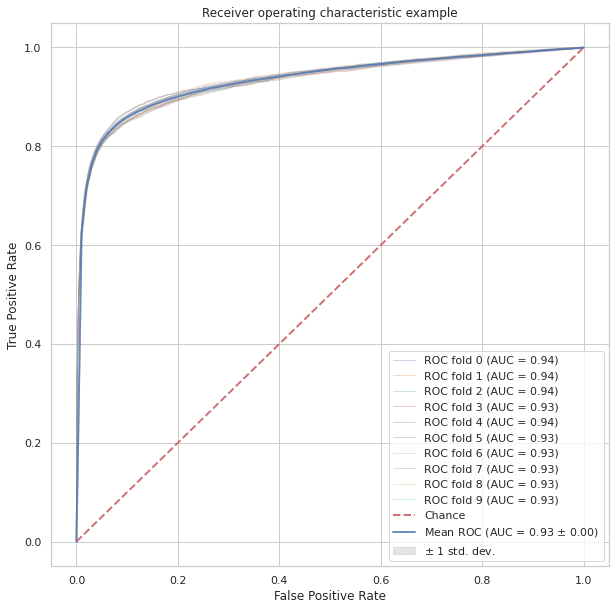

<Figure size 432x288 with 0 Axes>

In [ ]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
X = xArray.copy()
y = yArray.copy()

X.reset_index(inplace=True)
X.drop(columns={'index'}, inplace=True)

y.reset_index(inplace=True)
y.drop(columns={'index'}, inplace=True)

n_samples, n_features = X.shape

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[X.index.isin(train)], y[y.index.isin(train)])
    viz = plot_roc_curve(classifier, X[X.index.isin(test)], y[y.index.isin(test)],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

plt.savefig('ROC_KFold_10.png', dpi=300)

#### Matrix de Confusão

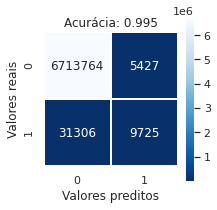

In [ ]:
y_pred = cross_val_predict(logreg, xArray, yArray, cv=10)
acc = modelo_KFold['test_accuracy'].mean()
my_cm(confusion_matrix(yArray, y_pred), acc)
plt.savefig('CM_KFold.png', dpi=300)

#### Relatório de Classificação

In [ ]:
print(classification_report(yArray, y_pred))
report = classification_report(yArray, y_pred, output_dict=True)
round(pd.DataFrame(report).transpose(),2).to_csv('ClassRep_KFold.csv')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6719191
           1       0.64      0.24      0.35     41031

    accuracy                           0.99   6760222
   macro avg       0.82      0.62      0.67   6760222
weighted avg       0.99      0.99      0.99   6760222



## RFE (Eliminação recursiva de features)

A ideia da eliminação recursiva de feature (RFE) é selecionar features considerando recursivamente conjuntos cada vez menores de features, isso ocorre da seguinte forma. Primeiro, o estimador é treinado no conjunto inicial de features e a importância de cada feature é obtida por meio de um atributo "coef_" ou por meio de um atributo "feature_importances_". Em seguida, os features menos importantes são removidos do conjunto atual de features. Esse procedimento é repetido recursivamente no conjunto removido até que o número desejado de features a serem selecionados seja finalmente alcançado.

### Criando um modelo com número de features otimizado usando RFECV

RFECV executa RFE em um loop de validação cruzada para encontrar o número ideal ou o melhor número de features. No codigo abaixo temos uma eliminação de feature recursiva aplicada na regressão logística com ajuste automático do número de features selecionados com validação cruzada.


Como resultado o codigo trouxe 6 features que é o numero ideia de features para o modelo e trouxe também as melhores features sendo elas:

- 'tp_maternal_schooling'
- 'gestaional_week' 
- 'cd_apgar1' 
- 'cd_apgar5' 
- 'has_congenital_malformation'
- 'tp_labor'

In [ ]:
# Crie o objeto RFE e calcule uma pontuação com validação cruzada.
# A pontuação de "precisão" é proporcional ao número de classificações corretas
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(xArray, yArray)

print("Número ideal de Features: %d" % rfecv.n_features_)
print('Features Selecionadas: %s' % list(xArray.columns[rfecv.support_]))

# Número do lote das Features VS. pontuações de validação cruzada
plt.figure(figsize=(7,5))
plt.xlabel("Número de Features selecionadas")
plt.ylabel("Pontuação de validação cruzada (nb de classificações corretas)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Modelo Final: Usar apenas variáveis selecionadas e aplicar o GridSearchCV

No RFECV vc esta esclhendo mehlores features de sua base, no gridSearch vc esta escolhendo parametros do algorítmo.

In [ ]:
xArray_RFE = xArray[list(xArray.columns[rfecv.support_])]
xArray_RFE.head()

,tp_maternal_schooling,gestaional_week,cd_apgar1,cd_apgar5,has_congenital_malformation,tp_labor
6320935,5,39,9,10,2,2
4326756,1,38,8,9,2,1
1850457,4,32,5,8,2,1
6519241,4,37,9,10,2,1
1232531,5,37,9,10,2,2


Best params: LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best params: {'C': 1e-05}
Best score: 0.9946170406794806


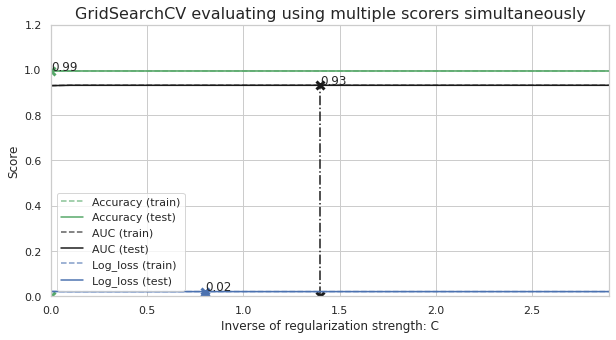

In [ ]:
param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(xArray_RFE, yArray)
results = gs.cv_results_

print('='*20)
print("Best params: " + str(gs.best_estimator_))
print("Best params: " + str(gs.best_params_))
print('Best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(10, 5))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.0, 1.2)

X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
 
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

#### MODELO FINAL: Usando modelo sugerido pelo Grid Search com variáveis selecionadas

In [ ]:
logReg_GS = LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelo_Final = cross_validate(logReg_GS, xArray_RFE, yArray, cv=10, 
                         scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print("%s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -modelo_Final['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else modelo_Final['test_%s' % list(scoring.values())[sc]].mean(), 
                               modelo_Final['test_%s' % list(scoring.values())[sc]].std()))


K-fold cross-validation results:
accuracy: 0.995 (+/-0.000)
log_loss: 0.021 (+/-0.000)
auc: 0.932 (+/-0.002)


#### Curva ROC

In [ ]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
X = xArray_RFE.copy()
y = yArray.copy()

X.reset_index(inplace=True)
X.drop(columns={'index'}, inplace=True)

y.reset_index(inplace=True)
y.drop(columns={'index'}, inplace=True)

n_samples, n_features = X.shape

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = logReg_GS

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[X.index.isin(train)], y[y.index.isin(train)])
    viz = plot_roc_curve(classifier, X[X.index.isin(test)], y[y.index.isin(test)],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

plt.savefig('ROC_KFold_Final.png', dpi=300)

#### Matriz de confusão

In [ ]:
y_pred = cross_val_predict(logReg_GS, xArray_RFE, yArray, cv=10)
acc = modelo_Final['test_accuracy'].mean()
my_cm(confusion_matrix(yArray, y_pred), acc)
plt.savefig('CM_Final.png', dpi=300)

#### Relatório de Classificação

In [ ]:
print(classification_report(yArray, y_pred))
report = classification_report(yArray, y_pred, output_dict=True)
round(pd.DataFrame(report).transpose(),2).to_csv('ClassRep_Final.csv')